# Data load

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

df = pd.read_csv("data/train.csv")
df.tail(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
701775,id0924227,1,1/1/16 0:01,1/1/16 0:13,1,-73.970108,40.759800,-73.989357,40.742989,N,736
701776,id0190469,2,1/1/16 0:00,1/1/16 0:14,5,-73.981743,40.719158,-73.938828,40.829182,N,849
701777,id1665586,1,1/1/16 0:00,1/1/16 0:22,1,-73.985085,40.747166,-73.958038,40.717491,N,1294


# Classify columns [Ignore, X, Y]

In [2]:
# ignore : id, dropoff_datetime
dfY = df[['trip_duration']]
dfX = df.iloc[:,1:-1];del dfX['dropoff_datetime']

dfX.head(3)

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,1,4/30/16 23:59,1,-73.987793,40.724792,-73.975616,40.656445,N
1,1,4/30/16 23:59,1,-73.957596,40.717770,-73.951424,40.775230,N
2,1,4/30/16 23:59,2,-74.000954,40.742031,-73.947708,40.782200,N


# Manipulate column

## Add column

In [3]:
# Add 'distance' column
 # 위도 경도 사이의 거리 구하는 공식
  # 반지름 * arccos(sin(위도1)*sin(위도2)+cos(위도1)*cos(위도2)*cos(경도차))
   # 지구 반지름 : 6378.137km
   # 각 삼각함수 내에 들어가야 하는 파라미터 값은 radian value => degree * pi / 180 = np.radians()

p_la = np.radians(df['pickup_latitude'])
d_la = np.radians(df['dropoff_latitude'])
theta = np.radians(df['dropoff_longitude']-df['pickup_longitude'])

dfX['distance'] = 6378.137 * np.arccos(np.sin(p_la)*np.sin(d_la) + np.cos(p_la)*np.cos(d_la)*np.cos(theta))
dfX['distance'].fillna(0, inplace=True)

dfX.tail(3)

/Users/ray/.pyenv/versions/3.6.1/envs/python_dss/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arccos
  # This is added back by InteractiveShellApp.init_path()


,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance
701775,1,1/1/16 0:01,1,-73.970108,40.759800,-73.989357,40.742989,N,2.477347
701776,2,1/1/16 0:00,5,-73.981743,40.719158,-73.938828,40.829182,N,12.770911
701777,1,1/1/16 0:00,1,-73.985085,40.747166,-73.958038,40.717491,N,4.014623


## Split datetime into date and time

In [4]:
# split datetime into date and time
# http://strftime.org

df_split = dfX['pickup_datetime'].str.split(' ', expand=True)
df_date = df_split[0].str.split('/', expand=True)
df_time = df_split[1].str.split(':', expand=True)

dfX['pickup_month'] = df_date[0].astype(int)
dfX['pickup_date'] = df_date[1].astype(int)

dfX['pickup_hour'] = df_time[0].astype(int)
dfX['pickup_minute'] = df_time[1].astype(int)

del dfX['pickup_datetime']

dfX.tail(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance,pickup_month,pickup_date,pickup_hour,pickup_minute
701775,1,1,-73.970108,40.759800,-73.989357,40.742989,N,2.477347,1,1,0,1
701776,2,5,-73.981743,40.719158,-73.938828,40.829182,N,12.770911,1,1,0,0
701777,1,1,-73.985085,40.747166,-73.958038,40.717491,N,4.014623,1,1,0,0


#  Split dfX to CONtinuous value AND CATegorical value

## Split CONtinuous value : 10 columns

In [5]:
# 월, 일, 시, 분 은 연속 변수? 카테고리 변수? 대소판단이 가능하여 일단 연속변수에 넣었으나...
cols_con = ['passenger_count', 'pickup_month', 'pickup_date', 'pickup_hour', 'pickup_minute', 'distance',\
            'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

In [6]:
dfX_con = dfX[cols_con]
print(len(dfX_con.columns))
dfX_con.tail(3)

10


,passenger_count,pickup_month,pickup_date,pickup_hour,pickup_minute,distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
701775,1,1,1,0,1,2.477347,-73.970108,40.759800,-73.989357,40.742989
701776,5,1,1,0,0,12.770911,-73.981743,40.719158,-73.938828,40.829182
701777,1,1,1,0,0,4.014623,-73.985085,40.747166,-73.958038,40.717491


## Split CATegorical value : 2 columns

In [7]:
cols_cat = ['vendor_id', 'store_and_fwd_flag']

In [8]:
dfX_cat = dfX[cols_cat]
print(len(dfX_cat.columns))
dfX_cat.tail(3)

2


,vendor_id,store_and_fwd_flag
701775,1,N
701776,2,N
701777,1,N


## DESCRIBE CONtinuous values

In [9]:
print(len(dfX_con.describe().columns))
dfX_con.describe()

10


,passenger_count,pickup_month,pickup_date,pickup_hour,pickup_minute,distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000
mean,1.666577,2.542780,15.538534,13.637749,29.607258,3.401137,-73.973665,40.750969,-73.973583,40.751836
std,1.319466,1.111019,8.702017,6.379120,17.324218,4.253468,0.043910,0.033139,0.044214,0.037572
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-78.547401,34.359695,-79.817978,32.181141
25%,1.000000,2.000000,8.000000,9.000000,15.000000,1.222959,-73.991829,40.737400,-73.991325,40.735959
50%,1.000000,3.000000,15.000000,14.000000,30.000000,2.075242,-73.981789,40.754150,-73.979828,40.754478
75%,2.000000,4.000000,23.000000,19.000000,45.000000,3.827995,-73.967567,40.768246,-73.963249,40.769691
max,8.000000,4.000000,31.000000,23.000000,59.000000,892.212471,-61.335529,43.486885,-61.335529,43.674000


# Visualize CON

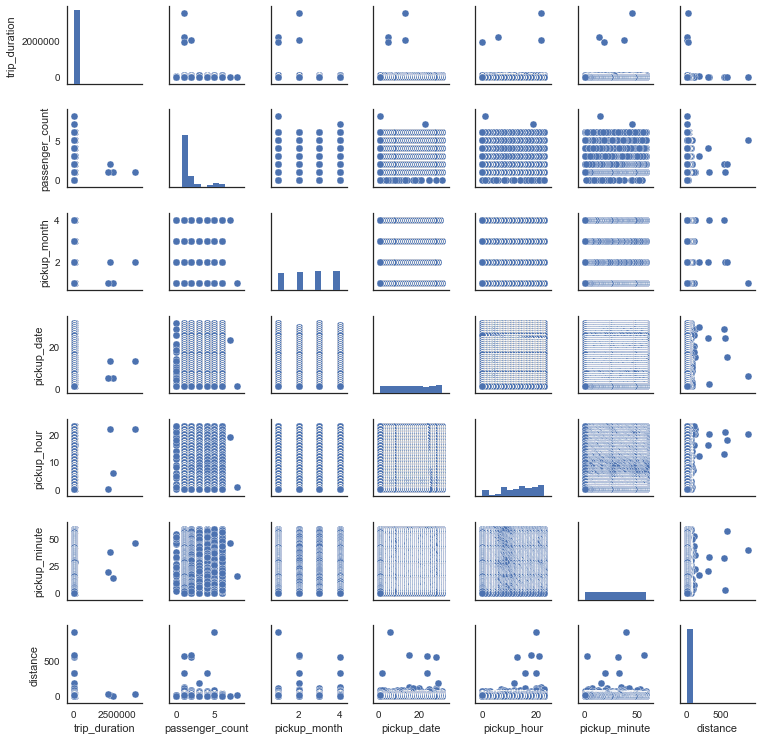

In [10]:
with plt.style.context(('seaborn-white')):
    sns_plot = sns.pairplot(pd.concat([dfY['trip_duration'], dfX[cols_con[:6]]], axis=1), size=1.5)
plt.show()

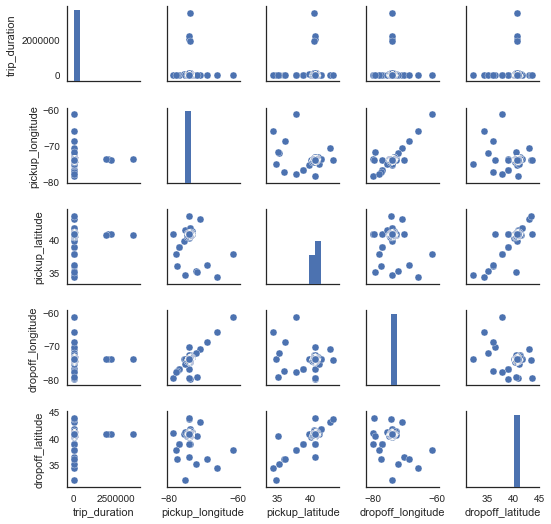

In [11]:
with plt.style.context(('seaborn-white')):
    sns_plot = sns.pairplot(pd.concat([dfY['trip_duration'], dfX[cols_con[6:]]], axis=1), size=1.5)
plt.show()

# Visualize CAT (Box plot)

In [12]:
def display_boxplot(feature):
    with plt.style.context(('seaborn-white')):
        sns.boxplot(x=dfX[feature], y=dfY['trip_duration'], linewidth=2, palette="Set1")

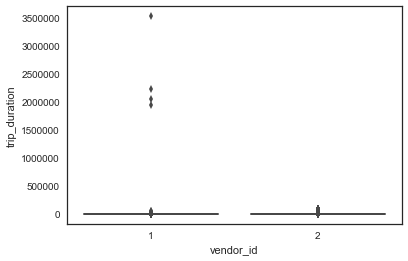

In [13]:
display_boxplot('vendor_id')
plt.show()

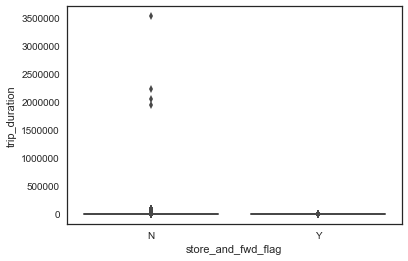

In [14]:
display_boxplot('store_and_fwd_flag')
plt.show()